## Fast Agent

<img src="./assets/LC_L1_top.png" align="left" width="500" />

First, let's set up our SQLite database connection using the Chinook sample database.


In [1]:
import * as setup from "./setup.ts";
import { SqlDatabase } from "@langchain/classic/sql_db";
import { DataSource } from "typeorm";

const datasource = new DataSource({
    type: "sqlite",
    database: "./Chinook.db", // Replace with the link to your database
});
const db = await SqlDatabase.fromDataSourceParams({
    appDataSource: datasource,
});

Disable LANGSMITH_TRACING in Deno kernel.


Create a tool that executes SQL queries against our database.

<b>⚠️ Security Note:</b> This demo does not include a filter on LLM-generated commands. In production, you would want to limit the scope of LLM-generated commands. ⚠️


In [2]:
import { tool } from "langchain";
import { z } from "zod";

export const executeSQL = tool(({ query }, runtime) => {
    return runtime.context.db.run(query)
}, {
    name: "execute_sql",
    description: "Execute a SQLite command and return results.",
    schema: z.object({ query: z.string() })
})

Define a system prompt with clear rules for the agent to follow when querying the database.


In [3]:
export const systemPrompt = `You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool \`execute_sql\` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.`

Now we can create our agent by combining the model, tools, and system prompt.


In [4]:
import * as z from "zod";
import { createAgent } from "langchain";

const contextSchema = z.object({
    db: z.instanceof(SqlDatabase),
});

const agent = createAgent({
    model: "anthropic:claude-sonnet-4-5-20250929",
    tools: [executeSQL],
    systemPrompt,
    contextSchema,
});

Let's visualize the agent's graph structure.


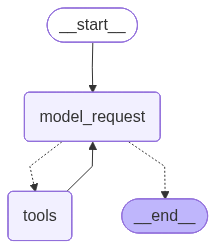

In [5]:
await agent.drawMermaidPng()

Run some queries. Notice:
- The agent does not have the database schema and will need to discover it independently.
- The agent may make mistakes! By returning error messages, the agent can self-correct its queries.
- Notice you invoke the agent with `agent.stream`.
- Notice the agent doesn't remember the schema between invocations... More on this later!

Time to test it! Let's ask which table has the most entries.


In [6]:
const stream = await agent.stream({
    messages: "Which table has the largest number of entries?"
}, {
    streamMode: "values",
    context: {
        db,
    }
})

for await (const step of stream) {
    const lastMessage = step?.messages?.at(-1)
    displayMessage(lastMessage)
}


┌────────────────────────────────────────────────────────────┐
│ 👤 HUMAN MESSAGE                                           │
└────────────────────────────────────────────────────────────┘
Which table has the largest number of entries?

┌────────────────────────────────────────────────────────────┐
│ 🤖 AI MESSAGE                                              │
└────────────────────────────────────────────────────────────┘
[
  {
    type: "text",
    text: "I'll help you find which table has the largest number of entries. First, let me see what tables exist in the database."
  },
  {
    type: "tool_use",
    id: "toolu_016GkyRZVDWJaHKDbyZshLtC",
    name: "execute_sql",
    input: { query: "SELECT name FROM sqlite_master WHERE type='table'" }
  }
]

┌────────────────────────────────────────────────────────────┐
│ 🔧 TOOL MESSAGE                                            │
└────────────────────────────────────────────────────────────┘
[{"name":"Album"},{"name":"Artist"},{"name":"Customer

Now let's try a more complex analytical query involving joins and aggregations.


In [7]:
const question = "Which genre on average has the longest tracks?"
const stream = await agent.stream({
    messages: question
}, {
    streamMode: "values",
    context: {
        db,
    }
})

for await (const step of stream) {
    const lastMessage = step?.messages?.at(-1)
    displayMessage(lastMessage)
}


┌────────────────────────────────────────────────────────────┐
│ 👤 HUMAN MESSAGE                                           │
└────────────────────────────────────────────────────────────┘
Which genre on average has the longest tracks?

┌────────────────────────────────────────────────────────────┐
│ 🤖 AI MESSAGE                                              │
└────────────────────────────────────────────────────────────┘
[
  {
    type: "text",
    text: "I'll help you find which genre has the longest average track length. Let me start by exploring the database structure."
  },
  {
    type: "tool_use",
    id: "toolu_0184Nnn9t7MdrtxkrLu2YvCa",
    name: "execute_sql",
    input: { query: "SELECT name FROM sqlite_master WHERE type='table'" }
  }
]

┌────────────────────────────────────────────────────────────┐
│ 🔧 TOOL MESSAGE                                            │
└────────────────────────────────────────────────────────────┘
[{"name":"Album"},{"name":"Artist"},{"name":"Customer

Let's ask for a simple list of all tables in the database.


In [8]:
const question = "What are all the tables?";
const stream = await agent.stream({
    messages: question
}, {
    streamMode: "values",
    context: {
        db,
    }
})

for await (const step of stream) {
    const lastMessage = step?.messages?.at(-1)
    displayMessage(lastMessage)
}


┌────────────────────────────────────────────────────────────┐
│ 👤 HUMAN MESSAGE                                           │
└────────────────────────────────────────────────────────────┘
What are all the tables?

┌────────────────────────────────────────────────────────────┐
│ 🤖 AI MESSAGE                                              │
└────────────────────────────────────────────────────────────┘
[
  {
    type: "text",
    text: "I'll query the SQLite system table to find all the tables in the database."
  },
  {
    type: "tool_use",
    id: "toolu_015xytgn4mY4SQBQDNH4CkQ4",
    name: "execute_sql",
    input: {
      query: "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name"
    }
  }
]

┌────────────────────────────────────────────────────────────┐
│ 🔧 TOOL MESSAGE                                            │
└────────────────────────────────────────────────────────────┘
[{"name":"Album"},{"name":"Artist"},{"name":"Customer"},{"name":"Employee"},{"name":"Genre"},{"

## Let's try this in the agent debugger!

The "Getting Setup" instructions describe how to get LangSmith Studio set up. If you are running the notebooks, you are probably already to go.
The messages are in a slightly different format than in the course video:
```typescript
{
  "messages":  "Which table has the largest number of entries?" 
}
```
With brackets in json format.   

Watch this video to see how to invoke it. 


<video src="assets/RunningStudio_H264.mp4" width="720" controls poster="assets/thumb.jpg" playsinline></video>